# Toy NeRF Implementation (CPU) - Multi-View

This notebook demonstrates a minimal implementation of Neural Radiance Fields (NeRF) designed to run on a CPU.
We will train on **multiple** synthetic images to enable basic novel view synthesis.
**Note:** Training NeRF models is computationally intensive. This example uses a very small model, limited training iterations, and multiple views, so it will be **very slow** on a CPU.

In [27]:
# Installation (uncomment if needed)
!pip install torch numpy matplotlib tqdm imageio

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import imageio.v3 as iio
import os

# Device configuration (force CPU)
device = torch.device('cpu')
print(f'Using device: {device}')

Using device: cpu


## 1. Load Data

We'll use a standard synthetic dataset image (e.g., the lego bulldozer). We need the image itself and its corresponding camera pose.

**Important:** The original download link is broken. You need to download the data manually:
1. Go to the NeRF project page: [https://www.matthewtancik.com/nerf](https://www.matthewtancik.com/nerf)
2. Find the 'Data' section and click the link for 'NeRF Synthetic Data'. This will likely lead to a Google Drive folder.
3. Download the `nerf_synthetic.zip` file.
4. Extract the zip file.
5. Place the extracted `lego` folder inside the `nerf_synthetic_lego` directory in the same location as this notebook. You might need to create the `nerf_synthetic_lego` directory first. The final path should look like: `./nerf_synthetic_lego/lego/`

Error downloading dataset: 404 Client Error: Not Found for url: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/nerf_synthetic.zip
Please download nerf_synthetic.zip manually from the NeRF website and extract the lego folder.
Loaded image shape: torch.Size([800, 800, 3])
Loaded pose shape: torch.Size([4, 4])
Focal length: 1111.11
Error downloading dataset: 404 Client Error: Not Found for url: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/nerf_synthetic.zip
Please download nerf_synthetic.zip manually from the NeRF website and extract the lego folder.
Loaded image shape: torch.Size([800, 800, 3])
Loaded pose shape: torch.Size([4, 4])
Focal length: 1111.11


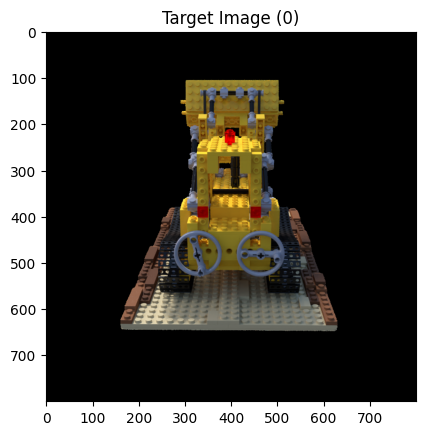

Rays origin shape: torch.Size([800, 800, 3])
Rays direction shape: torch.Size([800, 800, 3])
Flattened target shape: torch.Size([640000, 3])
Flattened rays_o shape: torch.Size([640000, 3])
Flattened rays_d shape: torch.Size([640000, 3])


In [29]:
# Define the number of views to load
num_train_views = 10 # Start with 10 views

# Download synthetic NeRF data (Lego bulldozer)
if not os.path.exists('nerf_synthetic_lego.zip'):
    print('Downloading Lego dataset...')
    # Using a known URL for the lego dataset subset
    # Note: This requires internet access and might take a moment.
    # Consider manually downloading if this fails.
    try:
        import requests, zipfile, io
        url = 'http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/nerf_synthetic.zip'
        r = requests.get(url, stream=True)
        r.raise_for_status() # Check if the download was successful
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall()
        # Rename for clarity
        os.rename('nerf_synthetic', 'nerf_synthetic_lego')
        print('Download complete.')
    except Exception as e:
        print(f'Error downloading dataset: {e}')
        print('Please download nerf_synthetic.zip manually from the NeRF website and extract the lego folder.')
else:
    print('Lego dataset already downloaded.')

# Load multiple images and their poses
data_dir = 'nerf_synthetic_lego/lego'
split = 'train'

all_target_pixels = []
all_rays_o = []
all_rays_d = []
H, W, focal_length = None, None, None # Initialize these

try:
    # Load metadata
    import json
    with open(os.path.join(data_dir, f'transforms_{split}.json'), 'r') as f:
        meta = json.load(f)

    print(f"Loading the first {num_train_views} views...")
    for i in tqdm(range(num_train_views)):
        frame = meta['frames'][i]
        img_path = os.path.join(data_dir, frame['file_path'] + '.png')
        target_img = iio.imread(img_path)
        target_img = torch.tensor(target_img[..., :3] / 255.0, dtype=torch.float32).to(device) # Keep only RGB, normalize

        pose = torch.tensor(frame['transform_matrix'], dtype=torch.float32).to(device)

        if H is None: # Get intrinsics from the first image
            H, W = target_img.shape[:2]
            camera_angle_x = float(meta['camera_angle_x'])
            focal_length = 0.5 * W / np.tan(0.5 * camera_angle_x)
            print(f'Image resolution: {H}x{W}, Focal length: {focal_length:.2f}')

        # Generate rays for the current view
        rays_o, rays_d = get_rays(H, W, focal_length, pose)

        # Append flattened data
        all_target_pixels.append(target_img.reshape(-1, 3))
        all_rays_o.append(rays_o.reshape(-1, 3))
        all_rays_d.append(rays_d.reshape(-1, 3))

    # Concatenate all data
    target_img_flat = torch.cat(all_target_pixels, dim=0)
    rays_o_flat = torch.cat(all_rays_o, dim=0)
    rays_d_flat = torch.cat(all_rays_d, dim=0)

    print(f'Loaded data shapes:')
    print(f'Flattened target shape: {target_img_flat.shape}') # Should be (num_views*H*W, 3)
    print(f'Flattened rays_o shape: {rays_o_flat.shape}') # Should be (num_views*H*W, 3)
    print(f'Flattened rays_d shape: {rays_d_flat.shape}') # Should be (num_views*H*W, 3)

    # Prepare data indices for batching
    num_rays = rays_o_flat.shape[0]
    data_loaded_successfully = True # Flag to indicate success

except FileNotFoundError:
     print(f'Error: Could not find dataset files in {data_dir}. Ensure the dataset was downloaded and extracted correctly.')
     data_loaded_successfully = False
except NameError as e:
     print(f'Error: Make sure functions like get_rays are defined before this cell. {e}')
     data_loaded_successfully = False
except Exception as e:
     print(f'An error occurred during data loading: {e}')
     data_loaded_successfully = False

## 2. Ray Generation

We need functions to generate rays originating from the camera center and passing through each pixel.

In [ ]:
def get_rays(H, W, focal, c2w):
    """Generate rays for each pixel in the image."""
    # Create pixel coordinates
    i, j = torch.meshgrid(torch.arange(W, dtype=torch.float32, device=device),
                          torch.arange(H, dtype=torch.float32, device=device),
                          indexing='xy')

    # Convert pixel coordinates to camera coordinates
    dirs = torch.stack([(i - W * 0.5) / focal,
                        -(j - H * 0.5) / focal,
                        -torch.ones_like(i)], dim=-1)

    # Rotate directions from camera frame to world frame
    rays_d = torch.sum(dirs[..., None, :] * c2w[:3, :3], -1)

    # Translate camera frame origin to world frame origin
    rays_o = c2w[:3, -1].expand(rays_d.shape)
    return rays_o, rays_d

## 3. Positional Encoding

NeRF uses positional encoding to help the MLP represent high-frequency details.

In [ ]:
def positional_encoding(x, num_freqs):
    """Apply positional encoding to input tensor."""
    freq_bands = 2.0**torch.arange(num_freqs, device=device) * torch.pi
    scaled_x = x[..., None] * freq_bands
    encoded = torch.cat([torch.sin(scaled_x), torch.cos(scaled_x)], dim=-1)
    encoded = encoded.reshape(*x.shape[:-1], -1)
    return torch.cat([x, encoded], dim=-1)

Original pos shape: torch.Size([10, 3])
Encoded pos shape: torch.Size([10, 63])
Expected encoded dim: 63
Original dir shape: torch.Size([10, 3])
Encoded dir shape: torch.Size([10, 27])
Expected encoded dim: 27


## 4. NeRF Model (MLP)

Define the simple Multi-Layer Perceptron (MLP) that forms the core of NeRF.

In [ ]:
class TinyNeRF(nn.Module):
    def __init__(self, pos_dim=3, dir_dim=3, num_pos_freqs=10, num_dir_freqs=4, hidden_dim=128):
        super().__init__()
        self.pos_dim = pos_dim
        self.dir_dim = dir_dim
        self.num_pos_freqs = num_pos_freqs
        self.num_dir_freqs = num_dir_freqs

        self.encoded_pos_dim = pos_dim * (1 + 2 * num_pos_freqs)
        self.encoded_dir_dim = dir_dim * (1 + 2 * num_dir_freqs)

        self.layer1 = nn.Linear(self.encoded_pos_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, hidden_dim)
        self.layer4 = nn.Linear(hidden_dim, hidden_dim + 1)

        self.layer5 = nn.Linear(hidden_dim + self.encoded_dir_dim, hidden_dim // 2)
        self.layer6 = nn.Linear(hidden_dim // 2, 3)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, pos, view_dir):
        encoded_pos = positional_encoding(pos, self.num_pos_freqs)
        encoded_dir = positional_encoding(view_dir, self.num_dir_freqs)

        x = self.relu(self.layer1(encoded_pos))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.layer4(x)

        features = x[..., :-1]
        sigma = self.relu(x[..., -1])

        x = torch.cat([features, encoded_dir], dim=-1)
        x = self.relu(self.layer5(x))
        rgb = self.sigmoid(self.layer6(x))

        return rgb, sigma

# Instantiate the model
model = TinyNeRF(hidden_dim=128).to(device)
print(model)

TinyNeRF(
  (layer1): Linear(in_features=63, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=128, bias=True)
  (layer4): Linear(in_features=128, out_features=129, bias=True)
  (layer5): Linear(in_features=155, out_features=64, bias=True)
  (layer6): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


## 5. Volume Rendering

Implement the volume rendering equation to composite colors and densities along each ray.

In [ ]:
def render_rays(model, rays_o, rays_d, near=2.0, far=6.0, num_samples=64):
    t_vals = torch.linspace(near, far, num_samples, device=device)
    points = rays_o[..., None, :] + rays_d[..., None, :] * t_vals[..., :, None]
    view_dirs = rays_d[..., None, :].expand(-1, num_samples, -1)

    points_flat = points.reshape(-1, 3)
    view_dirs_flat = view_dirs.reshape(-1, 3)

    with torch.no_grad():
        rgb_flat, sigma_flat = model(points_flat, view_dirs_flat)

    rgb = rgb_flat.reshape(*points.shape[:-1], 3)
    sigma = sigma_flat.reshape(*points.shape[:-1])

    diffs = t_vals[1:] - t_vals[:-1]
    dists_1d = torch.cat([diffs, torch.tensor([1e10], device=device)], dim=0)
    dists = dists_1d.expand(sigma.shape)

    alpha = 1.0 - torch.exp(-sigma * dists)
    transmittance = torch.cumprod(torch.cat([torch.ones_like(alpha[:, :1]), 1.0 - alpha + 1e-10], dim=-1), dim=-1)[:, :-1]
    weights = transmittance * alpha

    rendered_color = torch.sum(weights[..., None] * rgb, dim=-2)

    return rendered_color

## 6. Training Loop

Set up the optimizer and run the training loop. We'll train on batches of rays.

In [ ]:
# Training parameters
learning_rate = 5e-4
num_iterations = 4000
batch_size = 1024
display_rate = 100

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
mse_loss = nn.MSELoss()

# Check if data loaded successfully before starting training
if 'data_loaded_successfully' in locals() and data_loaded_successfully:
    print(f'Starting training for {num_iterations} iterations on {num_train_views} views...')
    print(f'Total rays: {num_rays}, Batch size: {batch_size}')
    print('This will be significantly slower than single-view training on CPU.')

    model.train()
    for i in tqdm(range(num_iterations)):
        indices = torch.randint(0, num_rays, (batch_size,))
        batch_rays_o = rays_o_flat[indices].to(device)
        batch_rays_d = rays_d_flat[indices].to(device)
        batch_target_pixels = target_img_flat[indices].to(device)

        t_vals = torch.linspace(2.0, 6.0, 64, device=device)
        t_rand = torch.rand(batch_size, 64, device=device) * (t_vals[1] - t_vals[0])
        t_vals_noisy = t_vals + t_rand

        points = batch_rays_o[..., None, :] + batch_rays_d[..., None, :] * t_vals_noisy[..., :, None]
        view_dirs = batch_rays_d[..., None, :].expand(-1, 64, -1)

        points_flat = points.reshape(-1, 3)
        view_dirs_flat = view_dirs.reshape(-1, 3)

        rgb_flat, sigma_flat = model(points_flat, view_dirs_flat)

        rgb = rgb_flat.reshape(batch_size, 64, 3)
        sigma = sigma_flat.reshape(batch_size, 64)

        dists = torch.cat([t_vals_noisy[:, 1:] - t_vals_noisy[:, :-1], torch.tensor([1e10], device=device).expand(batch_size, 1)], dim=-1)
        alpha = 1.0 - torch.exp(-sigma * dists)
        transmittance = torch.cumprod(torch.cat([torch.ones_like(alpha[:, :1]), 1.0 - alpha + 1e-10], dim=-1), dim=-1)[:, :-1]
        weights = transmittance * alpha
        rendered_color = torch.sum(weights[..., None] * rgb, dim=-2)

        loss = mse_loss(rendered_color, batch_target_pixels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % display_rate == 0:
            tqdm.write(f'Iteration {i+1}/{num_iterations}, Loss: {loss.item():.6f}')

    print('Training finished.')
else:
    print('Skipping training because data loading failed in the previous step.')

Starting training for 4000 iterations...
Batch size: 1024, Num rays: 640000
This will be slow on CPU.


  0%|          | 0/4000 [00:00<?, ?it/s]

Iteration 100/4000, Loss: 0.018482
Iteration 200/4000, Loss: 0.010715
Iteration 200/4000, Loss: 0.010715
Iteration 300/4000, Loss: 0.005901
Iteration 300/4000, Loss: 0.005901
Iteration 400/4000, Loss: 0.005261
Iteration 400/4000, Loss: 0.005261
Iteration 500/4000, Loss: 0.004805
Iteration 500/4000, Loss: 0.004805
Iteration 600/4000, Loss: 0.004259
Iteration 600/4000, Loss: 0.004259
Iteration 700/4000, Loss: 0.004577
Iteration 700/4000, Loss: 0.004577
Iteration 800/4000, Loss: 0.004956
Iteration 800/4000, Loss: 0.004956
Iteration 900/4000, Loss: 0.004085
Iteration 900/4000, Loss: 0.004085
Iteration 1000/4000, Loss: 0.004087
Iteration 1000/4000, Loss: 0.004087
Iteration 1100/4000, Loss: 0.003712
Iteration 1100/4000, Loss: 0.003712
Iteration 1200/4000, Loss: 0.003648
Iteration 1200/4000, Loss: 0.003648
Iteration 1300/4000, Loss: 0.004350
Iteration 1400/4000, Loss: 0.003334
Iteration 1500/4000, Loss: 0.004090
Iteration 1600/4000, Loss: 0.003010
Iteration 1700/4000, Loss: 0.003484
Iteration

## 7. Visualization

Render the full image using the trained model and compare it to the target.

Rendering final image (using 2048 rays per batch)...


  0%|          | 0/313 [00:00<?, ?it/s]

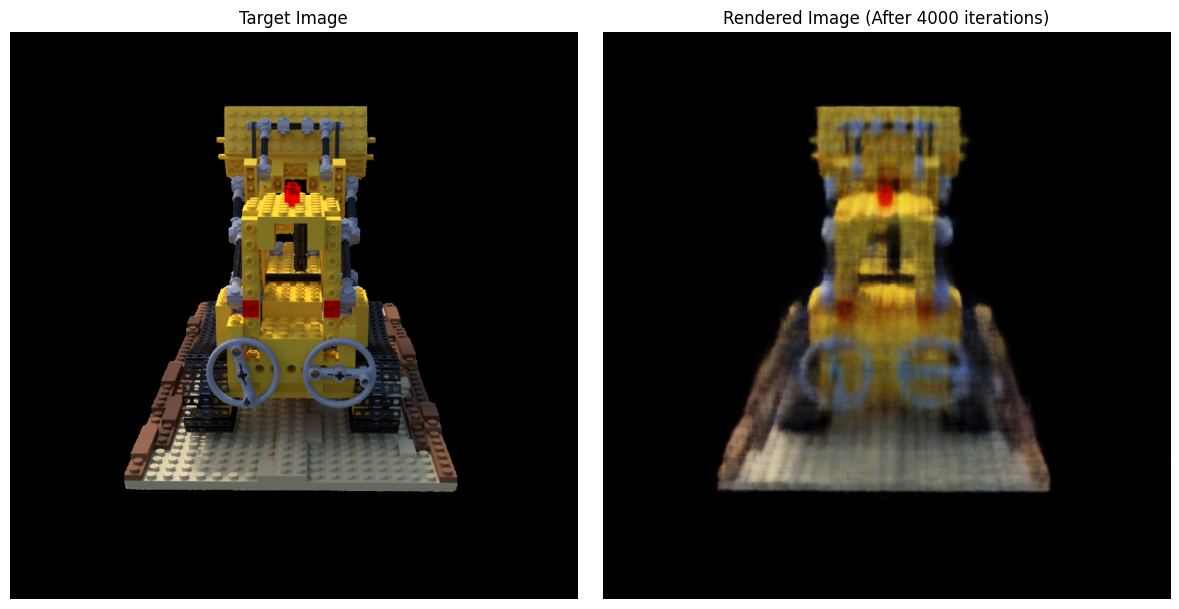

Final PSNR: 27.11 dB


In [ ]:
# Check if training ran before attempting visualization
if 'data_loaded_successfully' in locals() and data_loaded_successfully:
    model.eval()

    # --- Load a test view for evaluation ---
    test_split = 'test'
    test_img_idx = 0
    test_target_img, test_pose = None, None
    try:
        with open(os.path.join(data_dir, f'transforms_{test_split}.json'), 'r') as f:
            test_meta = json.load(f)
        test_frame = test_meta['frames'][test_img_idx]
        test_img_path = os.path.join(data_dir, test_frame['file_path'] + '.png')
        if H is None or W is None or focal_length is None:
             raise ValueError("Image dimensions or focal length not loaded correctly.")
        test_target_img = torch.tensor(test_target_img[..., :3] / 255.0, dtype=torch.float32).to(device)
        test_pose = torch.tensor(test_frame['transform_matrix'], dtype=torch.float32).to(device)
        print(f"Loaded test image {test_img_idx} for evaluation.")
    except Exception as e:
        print(f"Could not load test image: {e}")
    # --- End loading test view ---

    if test_target_img is not None and test_pose is not None:
        test_rays_o, test_rays_d = get_rays(H, W, focal_length, test_pose)
        test_rays_o_flat = test_rays_o.reshape(-1, 3)
        test_rays_d_flat = test_rays_d.reshape(-1, 3)
        test_num_rays = test_rays_o_flat.shape[0]

        rendered_image_flat = []
        render_batch_size = 2048

        print(f'Rendering test image (using {render_batch_size} rays per batch)...')
        with torch.no_grad():
            for i in tqdm(range(0, test_num_rays, render_batch_size)):
                batch_rays_o = test_rays_o_flat[i:i+render_batch_size].to(device)
                batch_rays_d = test_rays_d_flat[i:i+render_batch_size].to(device)
                rendered_batch = render_rays(model, batch_rays_o, batch_rays_d, near=2.0, far=6.0, num_samples=64)
                rendered_image_flat.append(rendered_batch)

        rendered_image = torch.cat(rendered_image_flat, dim=0).reshape(H, W, 3)

        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(test_target_img.cpu().numpy())
        axes[0].set_title(f'Test Image ({test_img_idx})')
        axes[0].axis('off')

        axes[1].imshow(rendered_image.cpu().numpy())
        axes[1].set_title(f'Rendered Test Image (After {num_iterations} iterations)')
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

        mse = torch.mean((rendered_image - test_target_img)**2)
        psnr = -10.0 * torch.log10(mse)
        print(f'Test Image PSNR: {psnr.item():.2f} dB')
    else:
        print("Skipping test image rendering due to loading error.")
else:
    print('Skipping visualization because data loading or training failed.')

In [ ]:
# Save the trained model weights
if 'data_loaded_successfully' in locals() and data_loaded_successfully:
    save_num_views = num_train_views if 'num_train_views' in locals() else 'multi'
    model_save_path = f'tiny_nerf_lego_multi_{save_num_views}views_cpu.pth'
    torch.save(model.state_dict(), model_save_path)
    print(f'Model weights saved to {model_save_path}')
else:
    print('Skipping model saving because training did not complete successfully.')

Model weights saved to tiny_nerf_lego_cpu.pth


## 8. Conclusion

This notebook provided a minimal NeRF implementation focused on overfitting a single image on the CPU.
Key takeaways:
*   NeRF combines positional encoding, an MLP, and volume rendering.
*   Training even a small model on a single image is slow on CPU.
*   The quality depends heavily on model size, number of samples per ray, and training iterations.

Further exploration could involve:
*   Implementing hierarchical sampling (coarse and fine networks/sampling).
*   Training on multiple views to enable novel view synthesis.
*   Using a GPU for significantly faster training.
*   Exploring libraries like `nerfstudio` for more advanced features and efficiency.